Read dimensions from shape file: depth=78, rows=512, cols=512
Read data size: 20447232
Max difference: 2895.569091796875
Mean difference: 193.62606811523438


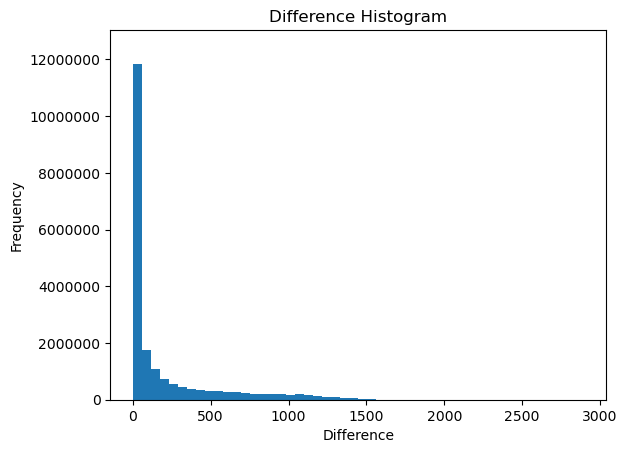

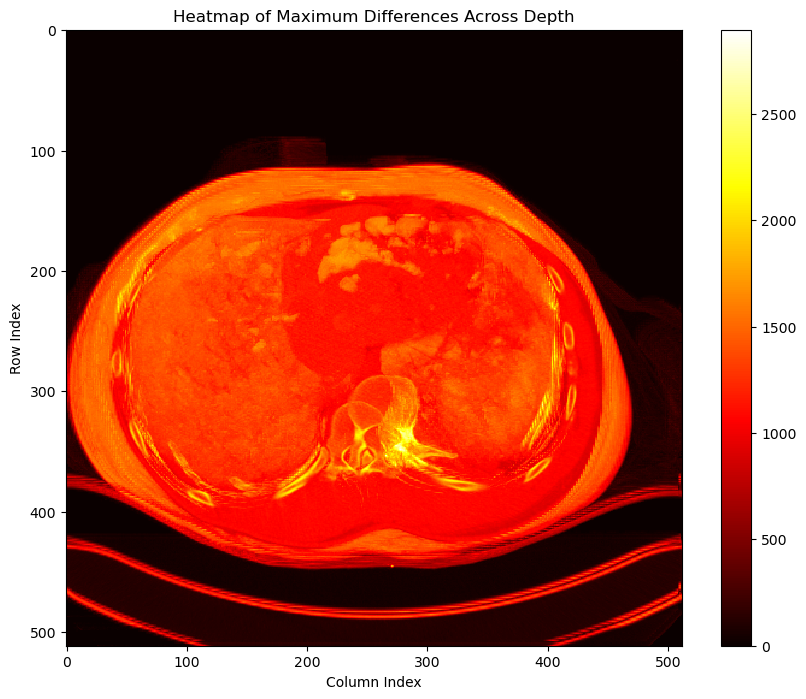

In [2]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import os

def read_shape_file(shape_filename):
    with open(shape_filename, 'r') as f:
        shape = tuple(map(int, f.read().strip().split(',')))
    return shape

def read_binary_file(filename, shape_filename):
    depth, rows, cols = read_shape_file(shape_filename)
    print(f"Read dimensions from shape file: depth={depth}, rows={rows}, cols={cols}")
    
    with open(filename, 'rb') as file:
        data = np.fromfile(file, dtype=np.float32)
        print(f"Read data size: {data.size}")
        
        data = data.reshape((depth, rows, cols))
    return data

def read_wavelet3d_result(filename):
    subbands = {}
    key_map = {
        'aaa': 'LLL', 'aad': 'LLH', 'ada': 'LHL', 'add': 'LHH',
        'daa': 'HLL', 'dad': 'HLH', 'dda': 'HHL', 'ddd': 'HHH'
    }
    with open(filename, 'rb') as file:
        for key in key_map:
            depth = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
            rows = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
            cols = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
            data = np.fromfile(file, dtype=np.float32, count=depth*rows*cols)
            data = data.reshape((depth, rows, cols))
            subbands[key_map[key]] = data
    return subbands

def crop_or_pad_data(data, target_shape):
    slices = tuple(slice(0, min(s, t)) for s, t in zip(data.shape, target_shape))
    cropped_data = data[slices]
    
    # Pad the data if necessary
    pad_widths = [(0, max(0, t - s)) for s, t in zip(cropped_data.shape, target_shape)]
    padded_data = np.pad(cropped_data, pad_widths, mode='constant', constant_values=0)
    
    return padded_data

def compare_data(original, reconstructed):
    difference = np.abs(original - reconstructed)
    max_diff = np.max(difference)
    mean_diff = np.mean(difference)
    print(f"Max difference: {max_diff}")
    print(f"Mean difference: {mean_diff}")
    
    # Plot the histogram of differences
    plt.hist(difference.flatten(), bins=50, range=(0, max_diff))
    plt.title('Difference Histogram')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')
    
    # Adjust the y-axis limit to make the scale more readable
    y_max = np.max(np.histogram(difference.flatten(), bins=50)[0]) * 1.1
    plt.ylim(0, y_max)
    
    # Set y-axis tick labels to show full values without scientific notation
    plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
    plt.show()
    
    return difference

def visualize_differences(difference):
    plt.figure(figsize=(10, 8))
    plt.imshow(difference.max(axis=0), cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Heatmap of Maximum Differences Across Depth')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()

def calculate_mse(original, reconstructed):
    return np.mean((original - reconstructed) ** 2)

# Create test data
binary_filename = "../../Final/data/3/3.bin"
shape_filename = "../../Final/data/3/3_shape.txt"
depth = 2
rows = 2
cols = 2

# Read the original input data
original_data = read_binary_file(binary_filename, shape_filename)

# Perform the 3D wavelet transform
coeffs = pywt.dwtn(original_data, 'db2', axes=(0, 1, 2))

# # Print all the subbands
# for key in coeffs.keys():
#     print(f"Subband {key}:")
#     print(coeffs[key])

# Write the wavelet coefficients to a file
wavelet_filename = '../../Final/serial/outputs/3out.bin'

# Read the results from the C++ implementation
data_cpp = read_wavelet3d_result(wavelet_filename)

# # Print the LLL subband of data_cpp
# print("LLL Subband of data_cpp:")
# print(data_cpp['LLH'])


# Get the target shape from the original data
target_shape = original_data.shape

# Define the reverse key map
reverse_key_map = {
    'LLL': 'aaa', 'LLH': 'aad', 'LHL': 'ada', 'LHH': 'add',
    'HLL': 'daa', 'HLH': 'dad', 'HHL': 'dda', 'HHH': 'ddd'
}

# Map the keys back to the expected format
data_cpp_mapped = {reverse_key_map[key]: value for key, value in data_cpp.items()}

# Perform the inverse 3D DWT
reconstructed_data_cpp = pywt.idwtn(data_cpp_mapped, 'db2', axes=(0, 1, 2))

# Get the target shape from the original data
target_shape = original_data.shape

# Crop or pad the reconstructed data to match the shape of the original data
reconstructed_data_cpp_cropped = crop_or_pad_data(reconstructed_data_cpp, target_shape)

# # Print original and reconstructed data
# print("Original Data:")
# print(original_data)
# print("Reconstructed Data:")
# print(reconstructed_data_cpp_cropped)

# Compare the original data with the cropped reconstructed data from C++ implementation
difference = compare_data(original_data, reconstructed_data_cpp_cropped)

# Visualize the differences
visualize_differences(difference)

# # Calculate and print MSE for each subband
# for key in coeffs.keys():
#     mse = calculate_mse(coeffs[key], data_cpp[key])
#     print(f"MSE for subband {key}: {mse}")

In [3]:
import numpy as np
import pywt

# Original 3D data
data = np.array([[[0, 1],
                  [2, 3]],

                 [[4, 5],
                  [6, 7]]])

# Perform 3D discrete wavelet transform
coeffs = pywt.dwtn(data, 'db2')

print("Reconstructed data:\n", coeffs)

Reconstructed data:
 {'aaa': array([[[ 4.94974747,  6.36396103],
        [ 7.77817459,  9.19238816]],

       [[10.60660172, 12.02081528],
        [13.43502884, 14.8492424 ]]]), 'aad': array([[[-1.22474487,  1.22474487],
        [-1.22474487,  1.22474487]],

       [[-1.22474487,  1.22474487],
        [-1.22474487,  1.22474487]]]), 'ada': array([[[-2.44948974, -2.44948974],
        [ 2.44948974,  2.44948974]],

       [[-2.44948974, -2.44948974],
        [ 2.44948974,  2.44948974]]]), 'add': array([[[-5.55111512e-17, -5.55111512e-17],
        [ 1.94289029e-16, -1.11022302e-16]],

       [[ 2.22044605e-16, -3.88578059e-16],
        [ 3.88578059e-16, -2.22044605e-16]]]), 'daa': array([[[-4.89897949, -4.89897949],
        [-4.89897949, -4.89897949]],

       [[ 4.89897949,  4.89897949],
        [ 4.89897949,  4.89897949]]]), 'dad': array([[[ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00]],

       [[-2.22044605e-16,  3.88578059e-16],
        [-5.55111512e-16,

In [4]:
import numpy as np

data = np.array([0, 1, 2, 3, 4, 5, 6, 7])
low_pass_filter = np.array([-0.12940952255126037, 0.2241438680420134, 0.8365163037378079, 0.48296291314453416])

# Perform convolution
conv_low = np.convolve(data, low_pass_filter, mode='full')

# Downsample by taking every second element
cA = conv_low[::2]

print("Convolution result with low-pass filter:", conv_low)
print("Downsampled approximation coefficients (cA):", cA)

Convolution result with low-pass filter: [ 0.         -0.12940952 -0.03467518  0.89657547  2.31078903  3.7250026
  5.13921616  6.55342972  9.00291946  8.75339161  3.38074039]
Downsampled approximation coefficients (cA): [ 0.         -0.03467518  2.31078903  5.13921616  9.00291946  3.38074039]
